# Utilización, procesamiento y visualización de grandes volúmenes de datos

Imanol Muñiz Ramirez A01701713

## Objetivo

Obtener un modelo de procesamiento del lenguaje natural que sea capaz de clasificar artículos cortos por su tema utilizando PySpark para el manejo de los datos y ML como framework de creación de modelos.

## Contexto

Para este proyecto seleccionamos dos datasets. El primero de ellos es WikiCAT_dataseset https://huggingface.co/datasets/PlanTL-GOB-ES/WikiCAT_esv2?utm_source=chatgpt.com y CC-NEWS-ES https://huggingface.co/datasets/LeoCordoba/CC-NEWS-ES?utm_source=chatgpt.com. WikiCAT Contiene artículos cortos categorizados en 12 temas distintos. Está separado en trainning y validación sumando en total 8.71 MB. CC-NEWS contiene artículos de distintos países sumando en total 7.62 GB de datos. Usarémos el primer conjunto de datos para entrenar al modelo y posteriormente harémos las predcciones del dataset de CC-NEWS.

## Creamos la sesión de Spark

Primero creamos la sesión de Spark con la que trabajaremos los datos. Añadimos las configuraciones adicionales para proporcionar mayor rendimiento de acuerdo al hardware con el que contamos.

In [1]:
import json
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, monotonically_increasing_id

os.environ["HADOOP_HOME"] = "C:\\hadoop"
os.environ["PATH"] += ";C:\\hadoop\\bin"

# 💡 Desactiva el uso de librerías nativas (previene el error UnsatisfiedLinkError)
os.environ["HADOOP_OPTIONAL_TOOLS"] = "hadoop-azure"
os.environ["JAVA_TOOL_OPTIONS"] = "-Djava.library.path=C:\\hadoop\\bin"
os.environ["HADOOP_OPTS"] = "-Djava.library.path=C:\\hadoop\\bin"
os.environ["HADOOP_USER_NAME"] = "hadoop"

print("Iniciando nueva sesión de Spark optimizada para 16GB RAM...")
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("BR JSON Reader") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.default.parallelism", "8") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.hadoop.hadoop.home.dir", "C:\\hadoop") \
    .config("spark.hadoop.home.dir", "C:\\hadoop") \
    .config("spark.hadoop.io.nativeio.native", "false") \
    .config("spark.hadoop.native.io.enable", "false") \
    .getOrCreate()

# Establecer nivel de log para reducir mensajes
spark.sparkContext.setLogLevel("WARN")

print("✓ Sesión de Spark iniciada con configuración optimizada para 16GB RAM")
print(f"  - Memoria del driver: 8GB")
print(f"  - Memoria del executor: 6GB")
print(f"  - Tamaño máximo de resultados: 4GB")

Iniciando nueva sesión de Spark optimizada para 16GB RAM...
✓ Sesión de Spark iniciada con configuración optimizada para 16GB RAM
  - Memoria del driver: 8GB
  - Memoria del executor: 6GB
  - Tamaño máximo de resultados: 4GB


## Pasamos los datos de WikiCAT de JSON a formato CSV

In [2]:
import csv

# Ruta del archivo JSON
json_files = []
json_files.append(r"D:\Tec\Septimo\Cloud\Global Superstore Analysis\hftrain_esv5.json")
json_files.append(r"D:\Tec\Septimo\Cloud\Global Superstore Analysis\hfeval_esv5.json")

for json_file in json_files:
    # Leer el archivo JSON
    print("Leyendo archivo JSON...")
    with open(json_file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)

    # Extraer el array de datos
    data_array = json_data['data']

    print(f"✓ Datos cargados: {len(data_array)} filas")
    print(f"\nColumnas disponibles: {list(data_array[0].keys())}")
    print(f"\nPrimeras 3 filas:")
    for i, row in enumerate(data_array[:3], 1):
        print(f"{i}. Label: {row['label']}, Sentence: {row['sentence'][:80]}...")

    # Preparar directorio de salida
    output_dir = "WikiCAT_dataset"
    os.makedirs(output_dir, exist_ok=True)

    if json_file.endswith("hftrain_esv5.json"):
        csv_file = f"{output_dir}/train_esv5.csv"
        print(f"\nGuardando como CSV en {csv_file}...")
    else:
        csv_file = f"{output_dir}/valid_esv5.csv"
        print(f"\nGuardando como CSV en {csv_file}...")

    # Escribir CSV directamente sin usar Spark (evita problemas en Windows)
    with open(csv_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
        
        # Escribir encabezado
        writer.writerow(['id', 'label', 'sentence'])
        
        # Escribir datos
        for idx, row in enumerate(data_array):
            # Limpiar saltos de línea en sentence
            sentence = row['sentence'].replace('\n', ' ').replace('\r', ' ')
            writer.writerow([idx, row['label'], sentence])

    print(f"✓ Dataset guardado exitosamente en {csv_file}")
    print(f"  Total de filas escritas: {len(data_array)}")

Leyendo archivo JSON...
✓ Datos cargados: 6716 filas

Columnas disponibles: ['sentence', 'label']

Primeras 3 filas:
1. Label: Economía, Sentence: En estadística, un modelo probit es un tipo de regresión donde la variable depen...
2. Label: Economía, Sentence: El libro diario o libro de cuentas es un libro contable donde se registran, día ...
3. Label: Economía, Sentence: La tarifa diaria promedio (comúnmente conocida como ADR - por sus siglas en ingl...

Guardando como CSV en WikiCAT_dataset/train_esv5.csv...
✓ Dataset guardado exitosamente en WikiCAT_dataset/train_esv5.csv
  Total de filas escritas: 6716
Leyendo archivo JSON...
✓ Datos cargados: 1685 filas

Columnas disponibles: ['sentence', 'label']

Primeras 3 filas:
1. Label: Economía, Sentence: La administración es una de las actividades humanas más importantes, encargada d...
2. Label: Economía, Sentence: El aprendizaje por la práctica o aprendizaje por la ejercitación y la repetición...
3. Label: Economía, Sentence: La clase so

## Obtenemos la información del CSV de WikiCAT 

Revisamos que se haya almacenado correctamente e imprimimos información útil para elaborar nuestro tablero de visualización

In [3]:
# Cargar el dataset WikiCAT desde CSV
print("Cargando dataset WikiCAT...")

df_wikicat = spark.read.csv(
    r"D:\Tec\Septimo\Cloud\Global Superstore Analysis\WikiCAT_dataset\train_esv5.csv",
    header=True,
    inferSchema=True,
    encoding="UTF-8"
)

print(f"✓ Dataset cargado: {df_wikicat.count()} filas")
print(f"\nColumnas: {df_wikicat.columns}")
print(f"\nEsquema:")
df_wikicat.printSchema()

print("\nPrimeras filas:")
df_wikicat.show(5, truncate=80)

print("\nDistribución de etiquetas:")
df_wikicat.groupBy("label").count().orderBy("count", ascending=False).show(10)

Cargando dataset WikiCAT...
✓ Dataset cargado: 6716 filas

Columnas: ['id', 'label', 'sentence']

Esquema:
root
 |-- id: integer (nullable = true)
 |-- label: string (nullable = true)
 |-- sentence: string (nullable = true)


Primeras filas:
+---+--------+--------------------------------------------------------------------------------+
| id|   label|                                                                        sentence|
+---+--------+--------------------------------------------------------------------------------+
|  0|Economía|En estadística, un modelo probit es un tipo de regresión donde la variable de...|
|  1|Economía|El libro diario o libro de cuentas es un libro contable donde se registran, d...|
|  2|Economía|La tarifa diaria promedio (comúnmente conocida como ADR - por sus siglas en i...|
|  3|Economía|En economía, el coste medio o costo medio es igual al coste total dividido po...|
|  4|Economía|"Para un individuo, el equivalente cierto C(p) de una lotería p es aquel

La distribución de los datos es la siguiente

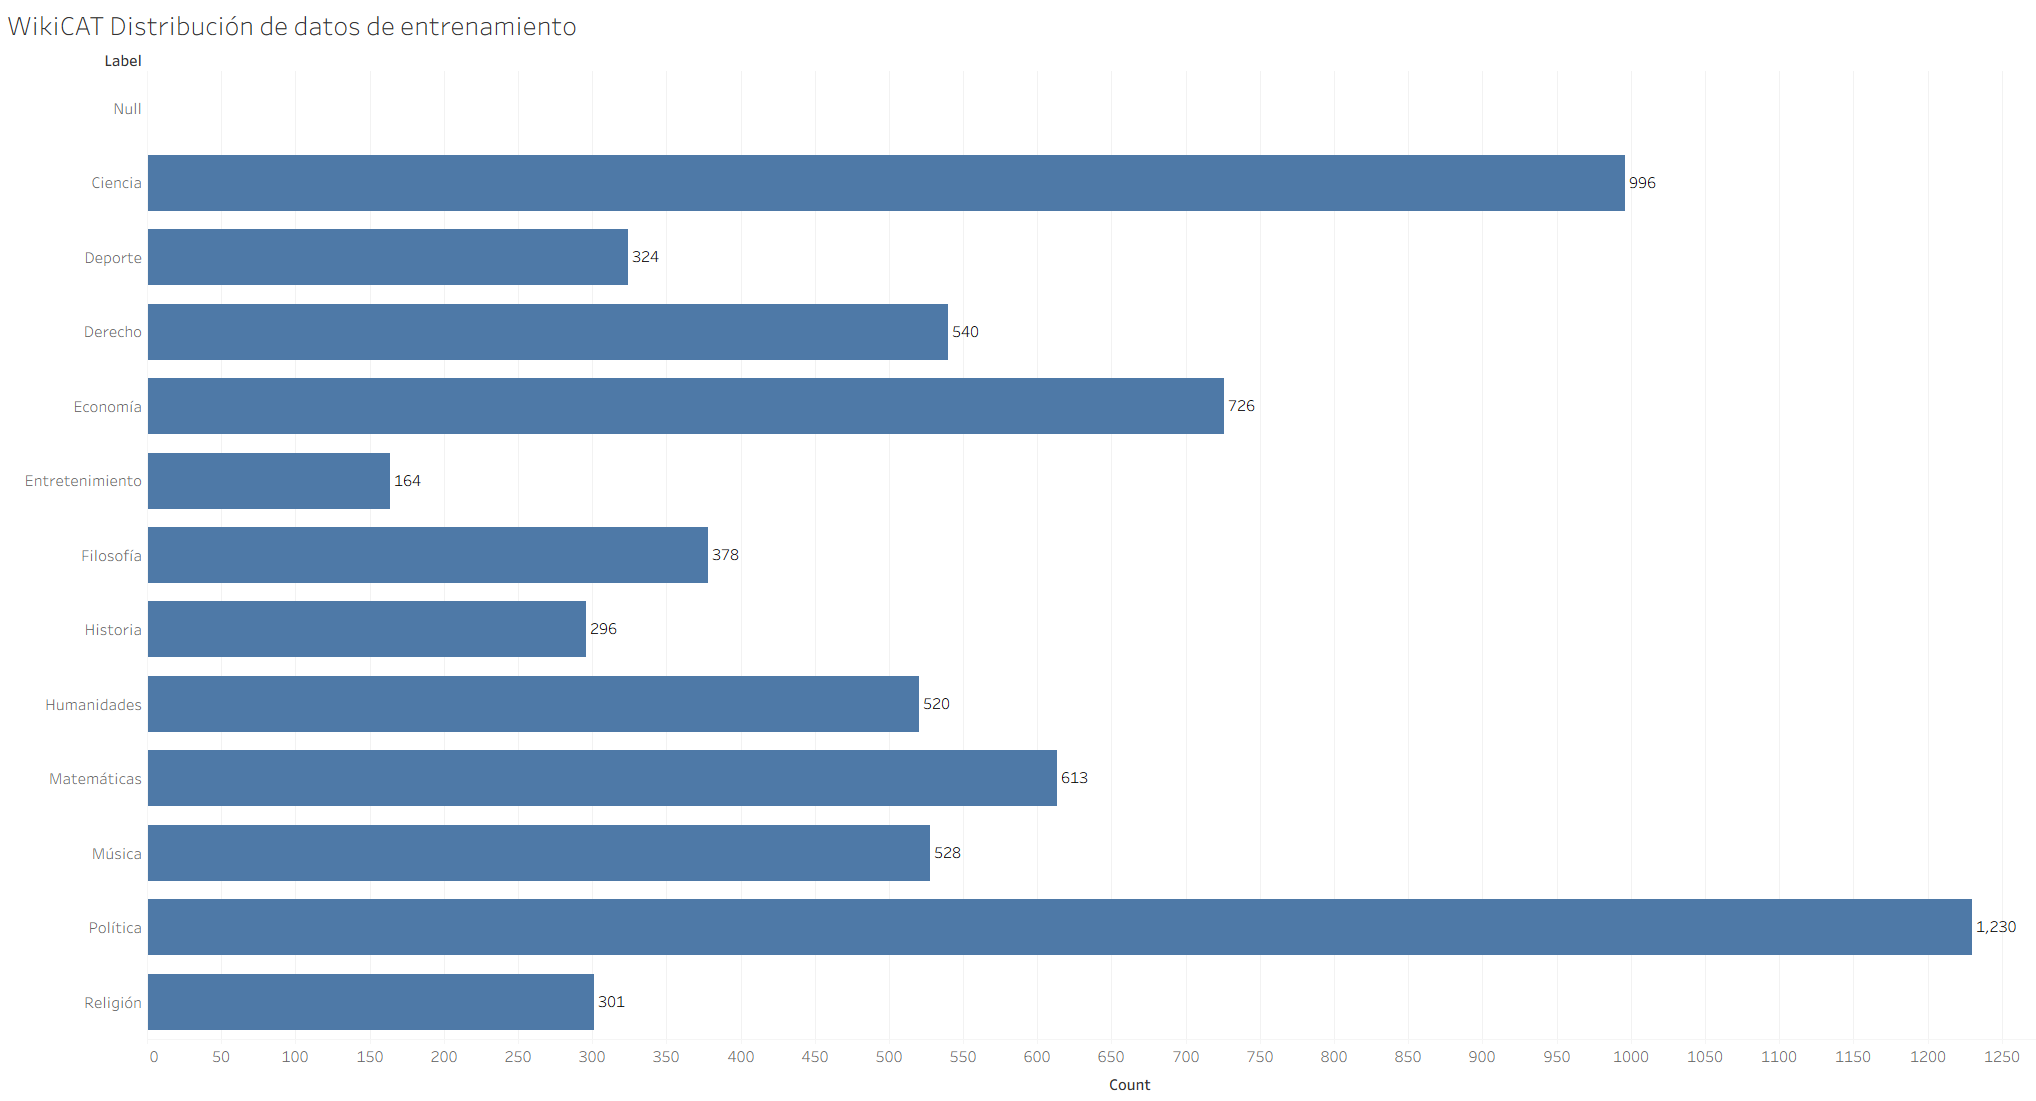

## Preparación de los datos del modelo

Aplicamos distintas tranformaciones a los datos: Adecuamos los nombres de las columnas, filtramos registros no válidos, tokenizamos el texto y vectorizamos las palabras.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, NGram, VectorAssembler
from pyspark.sql.functions import length, col, lower, trim, regexp_replace

# ===============================================
# === PREPARACIÓN DE DATOS PARA CLASIFICACIÓN ===
# ===============================================

print("="*60)
print("PREPARANDO DATOS WikiCAT PARA ENTRENAMIENTO")
print("="*60)

# === 1. Cargar datos de validación ===
print("\nCargando datos de validación...")
df_valid = spark.read.csv(
    r"D:\Tec\Septimo\Cloud\Global Superstore Analysis\WikiCAT_dataset\valid_esv5.csv",
    header=True,
    inferSchema=True,
    encoding="UTF-8"
)
print(f"✓ Datos de validación cargados: {df_valid.count()} documentos")

# === 2. Usar TODOS los datos de entrenamiento (sin muestra) ===
print("\nPreparando TODOS los datos de entrenamiento (sin muestreo)...")
df_train = df_wikicat.withColumnRenamed("sentence", "texto") \
                     .withColumnRenamed("label", "tema")

df_test = df_valid.withColumnRenamed("sentence", "texto") \
                  .withColumnRenamed("label", "tema")

print(f"✓ Dataset de entrenamiento: {df_train.count()} documentos")
print(f"✓ Dataset de validación: {df_test.count()} documentos")

# === 3. Limpieza avanzada de datos ===
print("\nAplicando limpieza avanzada de texto...")

def clean_data(df):
    # Limpieza de texto mejorada
    df = df.withColumn("texto", lower(col("texto")))  # Convertir a minúsculas
    df = df.withColumn("texto", trim(col("texto")))   # Eliminar espacios
    df = df.withColumn("texto", regexp_replace(col("texto"), r'\s+', ' '))  # Normalizar espacios
    
    # Filtrar documentos inválidos
    df = df.filter(col("texto").isNotNull())
    df = df.filter(col("texto") != "")
    df = df.filter(length(col("texto")) > 20)
    df = df.filter(col("tema").isNotNull())
    
    return df

train_data = clean_data(df_train)
test_data = clean_data(df_test)

print(f"✓ Entrenamiento después de limpieza: {train_data.count()} documentos")
print(f"✓ Validación después de limpieza: {test_data.count()} documentos")

# === 4. Análisis de temas ===
print("\n📊 Distribución de temas en entrenamiento:")
train_data.groupBy("tema").count().orderBy("count", ascending=False).show(15)

# === 5. Particionar datos para mejor rendimiento ===
train_data = train_data.repartition(8)
test_data = test_data.repartition(8)

# Mostrar ejemplos
print("\n📝 Ejemplos de datos de entrenamiento:")
train_data.select("tema", "texto").show(3, truncate=80)

# === 6. Configurar Pipeline de Preprocesamiento MEJORADO ===
print("\n" + "="*60)
print("CONFIGURANDO PIPELINE DE PREPROCESAMIENTO MEJORADO")
print("="*60)

# 6.1 Tokenizar texto
tokenizer = RegexTokenizer(
    inputCol="texto", 
    outputCol="palabras", 
    pattern="\\W",
    minTokenLength=3  # Ignorar palabras de menos de 3 caracteres
)

# 6.2 Remover stopwords en español
remover = StopWordsRemover(
    inputCol="palabras", 
    outputCol="palabras_limpias", 
    stopWords=StopWordsRemover.loadDefaultStopWords("spanish")
)

# 6.3 Convertir a vectores (Term Frequency) - REDUCIDO DRÁSTICAMENTE
cv = CountVectorizer(
    inputCol="palabras_limpias", 
    outputCol="rawFeatures", 
    vocabSize=10000,  
    minDF=5.0         # Solo palabras muy comunes
)

# 6.4 TF-IDF (relevancia de términos)
idf = IDF(
    inputCol="rawFeatures", 
    outputCol="features", 
    minDocFreq=2
)

# 6.5 Codificar etiquetas de temas como números
indexer = StringIndexer(
    inputCol="tema", 
    outputCol="label",
    handleInvalid="keep"  # Manejar temas nuevos
)

# === 7. Crear Pipeline Completo ===
preprocessing_pipeline = Pipeline(stages=[tokenizer, remover, cv, idf, indexer])

# === 8. Entrenar el pipeline de preprocesamiento ===
print("\n" + "="*60)
print("ENTRENANDO PIPELINE DE PREPROCESAMIENTO")
print("="*60)
print("Procesando TODOS los datos de entrenamiento...")
print("(Esto tomará varios minutos - usando dataset completo)")

preprocessing_model = preprocessing_pipeline.fit(train_data)

# Aplicar transformaciones
print("\nAplicando transformaciones...")
train_processed = preprocessing_model.transform(train_data)
test_processed = preprocessing_model.transform(test_data)

# Cachear para mejorar rendimiento
print("Cacheando datos procesados...")
train_processed.cache()
test_processed.cache()

# Forzar evaluación
train_count = train_processed.count()
test_count = test_processed.count()

# === 9. Mostrar resultados ===
print("\n" + "="*60)
print("✓ PREPROCESAMIENTO COMPLETADO EXITOSAMENTE")
print("="*60)

print(f"\n📊 Estadísticas:")
print(f"   - Documentos de entrenamiento procesados: {train_count:,}")
print(f"   - Documentos de validación procesados: {test_count:,}")

vocab = preprocessing_model.stages[2].vocabulary
print(f"   - Tamaño del vocabulario: {len(vocab):,}")

# Mapeo de temas
label_to_tema = preprocessing_model.stages[4].labels
print(f"   - Número de temas/categorías: {len(label_to_tema)}")

print("\n🏷️  Todos los temas encontrados:")
for i, tema in enumerate(label_to_tema):
    count = train_data.filter(col("tema") == tema).count()
    print(f"   {i:2d}: {tema:30s} ({count:,} documentos)")

print("\n📝 Muestra de datos procesados:")
train_processed.select("tema", "label", "palabras_limpias").show(3, truncate=80)

print("\n" + "="*60)
print("💾 DATOS LISTOS PARA ENTRENAMIENTO DEL MODELO")
print("="*60)
print("Variables disponibles:")
print("  - train_processed: TODOS los datos de entrenamiento preprocesados")
print("  - test_processed: datos de validación preprocesados")
print("  - preprocessing_model: modelo de preprocesamiento optimizado")
print("  - label_to_tema: mapeo de índices a nombres de temas")

PREPARANDO DATOS WikiCAT PARA ENTRENAMIENTO (MEJORADO)

Cargando datos de validación...
✓ Datos de validación cargados: 1685 documentos

Preparando TODOS los datos de entrenamiento (sin muestreo)...
✓ Dataset de entrenamiento: 6716 documentos
✓ Dataset de validación: 1685 documentos

Aplicando limpieza avanzada de texto...
✓ Entrenamiento después de limpieza: 6716 documentos
✓ Validación después de limpieza: 1685 documentos

📊 Distribución de temas en entrenamiento:
+--------------------+-----+
|                tema|count|
+--------------------+-----+
|            Política| 1230|
|Ciencia_y_Tecnología|  996|
|            Economía|  726|
|         Matemáticas|  613|
|             Derecho|  540|
|              Música|  528|
|         Humanidades|  520|
|            Historia|  396|
|           Filosofía|  378|
|             Deporte|  324|
|            Religión|  301|
|     Entretenimiento|  164|
+--------------------+-----+


📝 Ejemplos de datos de entrenamiento:
+-----------+------------

## Entrenamos el modelo

Usamos el framework de ML para utilizar un modelo de regresión logística que clasifique los vectores generados en el preprocesamiento del subconjunto de train y probamos el desempeño con los datos de evaluación. Imprimimos el resumen de los resultados y guardamos el modelo.

In [24]:
from pyspark.ml.classification import LogisticRegression, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when

# ===============================================
# === ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN MEJORADO ===
# ===============================================

print("="*60)
print("ENTRENANDO MODELO DE CLASIFICACIÓN MEJORADO")
print("="*60)

# === 1. Configurar el modelo MEJORADO ===
print("\nConfigurando Logistic Regression Mejorado...")
print("Parámetros optimizados para mayor accuracy...")

modelo_clasificacion = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,          # AUMENTADO de 50 a 100 iteraciones
    regParam=0.001,       # REDUCIDO de 0.01 a 0.001 (menos regularización)
    elasticNetParam=0.1,  # Mezcla L1 y L2 regularization
    tol=1e-6,             # Tolerancia más estricta
    standardization=True, # Normalizar features
    family="multinomial"  # Mejor para múltiples clases
)

# === 2. Entrenar el modelo con TODOS los datos ===
print("\n🏋️ Entrenando modelo con TODO el dataset de entrenamiento...")
print(f"Procesando {train_count:,} documentos de entrenamiento...")
print("(Esto puede tomar 10-15 minutos dependiendo del hardware)")

import time
start_time = time.time()

modelo_entrenado = modelo_clasificacion.fit(train_processed)

elapsed_time = time.time() - start_time
print(f"✓ Modelo entrenado exitosamente en {elapsed_time/60:.2f} minutos!")

# === 3. Hacer predicciones en datos de validación ===
print("\n📊 Evaluando modelo en datos de validación...")
predictions = modelo_entrenado.transform(test_processed)

# Cachear predicciones
predictions.cache()
pred_count = predictions.count()

# === 4. Evaluar el modelo con múltiples métricas ===
print("\n" + "="*60)
print("EVALUACIÓN DETALLADA DEL MODELO")
print("="*60)

# Evaluar Accuracy (Precisión)
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = evaluator_accuracy.evaluate(predictions)

# Evaluar F1 Score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="f1"
)
f1_score = evaluator_f1.evaluate(predictions)

# Evaluar Weighted Precision
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="weightedPrecision"
)
precision = evaluator_precision.evaluate(predictions)

# Evaluar Weighted Recall
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="weightedRecall"
)
recall = evaluator_recall.evaluate(predictions)

print(f"\n📈 MÉTRICAS DE EVALUACIÓN:")
print(f"   ✓ Accuracy (Precisión Global):    {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   ✓ F1 Score:                       {f1_score:.4f} ({f1_score*100:.2f}%)")
print(f"   ✓ Weighted Precision:             {precision:.4f} ({precision*100:.2f}%)")
print(f"   ✓ Weighted Recall:                {recall:.4f} ({recall*100:.2f}%)")

# === 5. Análisis detallado de predicciones ===
print("\n" + "="*60)
print("ANÁLISIS DETALLADO DE PREDICCIONES")
print("="*60)

# Contar predicciones correctas e incorrectas
predictions_analysis = predictions.withColumn(
    "correcto",
    when(col("label") == col("prediction"), 1).otherwise(0)
)

total_correct = predictions_analysis.filter(col("correcto") == 1).count()
total_incorrect = predictions_analysis.filter(col("correcto") == 0).count()

print(f"\n✅ Predicciones correctas:   {total_correct:,} ({total_correct/pred_count*100:.2f}%)")
print(f"❌ Predicciones incorrectas: {total_incorrect:,} ({total_incorrect/pred_count*100:.2f}%)")

# === 6. Ejemplos de predicciones ===
print("\n✅ EJEMPLOS DE PREDICCIONES CORRECTAS (5 aleatorias):")
predictions_correctas = predictions_analysis.filter(col("correcto") == 1)
predictions_correctas.select("tema", "texto").show(5, truncate=100)

print("\n❌ EJEMPLOS DE PREDICCIONES INCORRECTAS (5 aleatorias):")
predictions_incorrectas = predictions_analysis.filter(col("correcto") == 0)
if total_incorrect > 0:
    # Mostrar tema real vs predicho - SIN USAR UDF
    # Crear un mapeo usando broadcasting
    print("   Mostrando ejemplos de errores:")
    
    # Simplemente mostrar label y prediction como números
    predictions_incorrectas.select(
        "tema", 
        col("label").alias("label_real"),
        col("prediction").alias("label_predicho"),
        "texto"
    ).show(5, truncate=100)
    
    # Crear mapeo de labels a temas para interpretar
    print("\n   Mapeo de índices a temas:")
    for i, tema in enumerate(label_to_tema[:10]):  # Mostrar primeros 10
        print(f"   {i}: {tema}")
else:
    print("   ¡No hay predicciones incorrectas! Modelo perfecto ✨")

# === 7. Análisis por tema (Performance individual) ===
print("\n" + "="*60)
print("📊 PERFORMANCE POR TEMA (ACCURACY INDIVIDUAL)")
print("="*60)

tema_stats = predictions_analysis.groupBy("tema").agg(
    {"correcto": "sum", "tema": "count"}
).withColumnRenamed("sum(correcto)", "correctos") \
 .withColumnRenamed("count(tema)", "total")

tema_stats = tema_stats.withColumn(
    "accuracy_tema",
    (col("correctos") / col("total") * 100)
)

print("\nTop 10 temas con mejor accuracy:")
tema_stats.orderBy(col("accuracy_tema").desc()).show()

print("\nTop 10 temas con menor accuracy (necesitan mejora):")
tema_stats.orderBy(col("accuracy_tema").asc()).show(10, truncate=False)

# Guardar estadísticas de performance por tema en CSV
print("\n💾 Guardando estadísticas de performance por tema...")
tema_stats_ordenado = tema_stats.orderBy(col("accuracy_tema").desc())

# Guardar con Spark (un solo archivo)
temp_stats_dir = "temp_tema_stats"
tema_stats_ordenado.coalesce(1).write.mode("overwrite").option("header", "true").csv(temp_stats_dir)

# Mover el archivo CSV al nombre deseado
import glob
import shutil
csv_parts = glob.glob(f"{temp_stats_dir}/*.csv")
if csv_parts:
    stats_csv_file = "performance_por_tema.csv"
    shutil.move(csv_parts[0], stats_csv_file)
    shutil.rmtree(temp_stats_dir)
    print(f"✓ Estadísticas guardadas en: {stats_csv_file}")

# === 8. Guardar el modelo completo ===
print("\n" + "="*60)
print("💾 GUARDANDO MODELO MEJORADO")
print("="*60)

try:
    # Guardar modelo de preprocesamiento
    preprocessing_model.write().overwrite().save("modelo_preprocessing_wikicat_mejorado")
    print("✓ Modelo de preprocesamiento guardado: modelo_preprocessing_wikicat_mejorado")
    
    # Guardar modelo de clasificación
    modelo_entrenado.write().overwrite().save("modelo_clasificacion_wikicat_mejorado")
    print("✓ Modelo de clasificación guardado: modelo_clasificacion_wikicat_mejorado")
    
    # Guardar mapeo de etiquetas
    import pickle
    with open("label_to_tema_mapping.pkl", "wb") as f:
        pickle.dump(label_to_tema, f)
    print("✓ Mapeo de etiquetas guardado: label_to_tema_mapping.pkl")
    
    # Guardar métricas
    metricas = {
        "accuracy": accuracy,
        "f1_score": f1_score,
        "precision": precision,
        "recall": recall,
        "train_count": train_count,
        "test_count": test_count,
        "vocab_size": len(vocab),
        "num_temas": len(label_to_tema)
    }
    with open("metricas_modelo.pkl", "wb") as f:
        pickle.dump(metricas, f)
    print("✓ Métricas guardadas: metricas_modelo.pkl")
    
except Exception as e:
    print(f"⚠ Error al guardar: {e}")

# === 9. Resumen final ===
print("\n" + "="*60)
print("🎉 ENTRENAMIENTO COMPLETADO EXITOSAMENTE")
print("="*60)

print(f"\n📊 RESUMEN FINAL:")
print(f"   • Documentos de entrenamiento: {train_count:,}")
print(f"   • Documentos de validación: {test_count:,}")
print(f"   • Número de temas: {len(label_to_tema)}")
print(f"   • Tamaño del vocabulario: {len(vocab):,} palabras")
print(f"   • Iteraciones del modelo: 100")
print(f"   • Tiempo de entrenamiento: {elapsed_time/60:.2f} minutos")
print(f"\n   🎯 ACCURACY FINAL: {accuracy*100:.2f}%")
print(f"   🎯 F1 SCORE: {f1_score*100:.2f}%")

print("\n💾 Modelos guardados y listos para usar")
print("✓ Siguiente paso: usar el modelo para clasificar nuevos textos")

ENTRENANDO MODELO DE CLASIFICACIÓN MEJORADO

Configurando Logistic Regression Mejorado...
Parámetros optimizados para mayor accuracy...

🏋️ Entrenando modelo con TODO el dataset de entrenamiento...
Procesando 6,716 documentos de entrenamiento...
(Esto puede tomar 10-15 minutos dependiendo del hardware)
✓ Modelo entrenado exitosamente en 0.35 minutos!

📊 Evaluando modelo en datos de validación...

EVALUACIÓN DETALLADA DEL MODELO
✓ Modelo entrenado exitosamente en 0.35 minutos!

📊 Evaluando modelo en datos de validación...

EVALUACIÓN DETALLADA DEL MODELO

📈 MÉTRICAS DE EVALUACIÓN:
   ✓ Accuracy (Precisión Global):    0.6475 (64.75%)
   ✓ F1 Score:                       0.6452 (64.52%)
   ✓ Weighted Precision:             0.6469 (64.69%)
   ✓ Weighted Recall:                0.6475 (64.75%)

ANÁLISIS DETALLADO DE PREDICCIONES

📈 MÉTRICAS DE EVALUACIÓN:
   ✓ Accuracy (Precisión Global):    0.6475 (64.75%)
   ✓ F1 Score:                       0.6452 (64.52%)
   ✓ Weighted Precision:        

Podemos concluir del modelo tiene un margen de mejora considerable pues solo tiene alrededor de un 64% de presición. En la imagen de abajo podemos analizar mejor el desempeño del modelo en cada uno de los temas que categoriza. Es posible que se requiera un modelo más robusto para aumentar la presición.

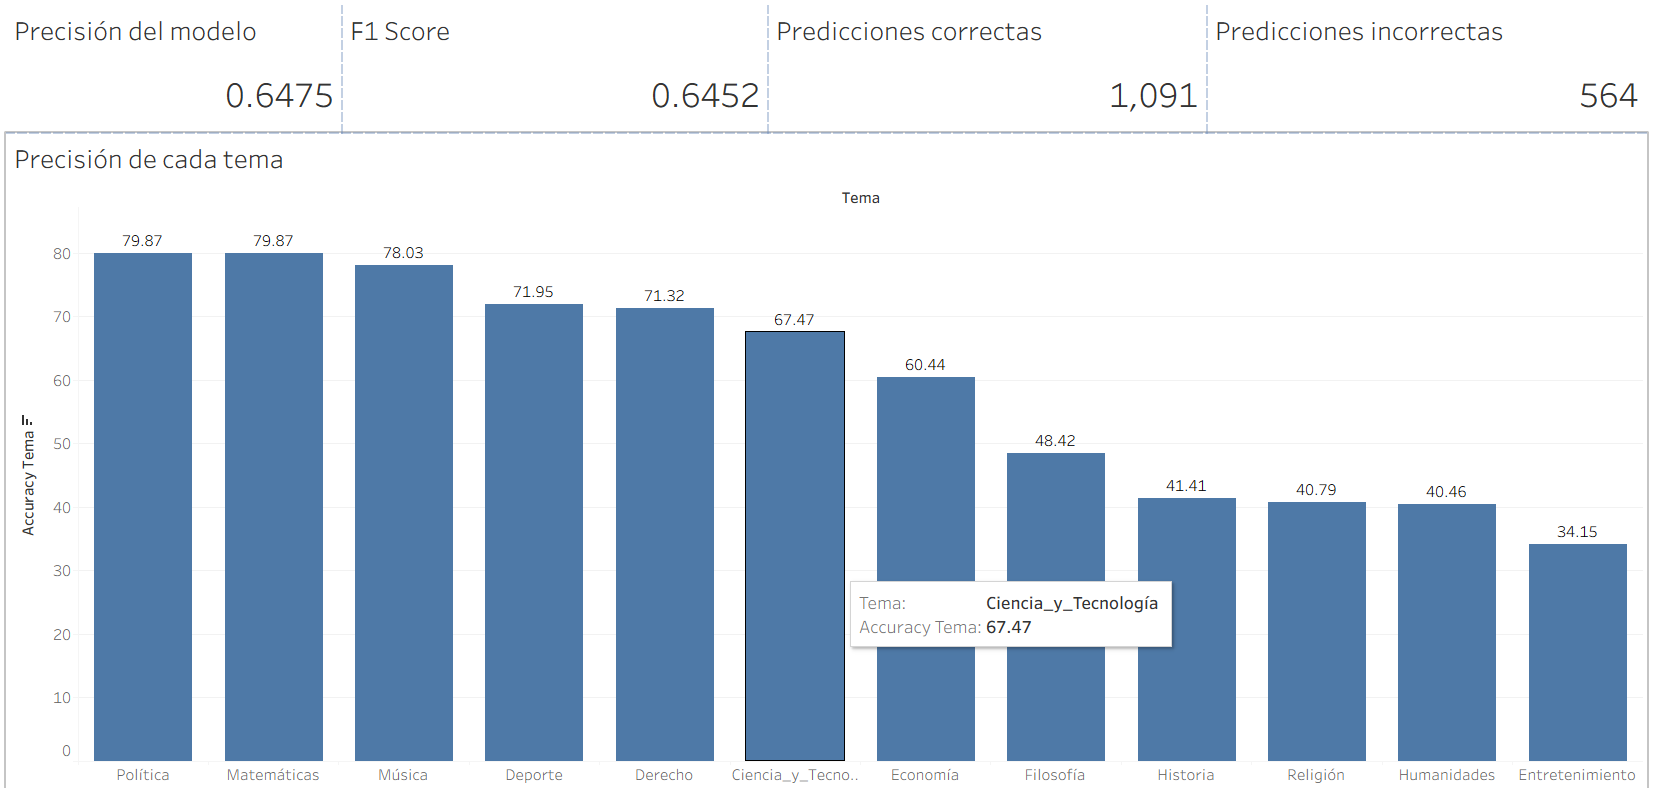

## Procesar información de CC-NEWS-ES



Los datos de CC-NEWS-ES vienen en archivos JSON de una sola línea. Son arreglos que contienen objetos con los atributos id, country y text. Por lo que necesitamos primero convertir a csv.

In [6]:
df = spark.read.option("multiline", "true").json("D:\\Tec\\Septimo\\Cloud\\Global Superstore Analysis\\CC-NEWS-ES\\ar\\ar.json")

# Selecciona solo las columnas que te interesan
df_simple = df.select("id", "text")

df_simple.show(5, truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Guardamos los resultados en un CSV. 
Posteriormente comentamos esta tarea para no hacerlo cada vez que corramos el archivo. 

In [ ]:
# Save df_simple to CSV
'''
df_simple.coalesce(1) \
    .write.mode("overwrite") \
    .option("header", "true") \
    .csv("file:///D:\\Tec\\Septimo\\Cloud\\Global Superstore Analysis\\br_texts")
    '''

'\ndf_simple.coalesce(1)     .write.mode("overwrite")     .option("header", "true")     .csv("file:///D:\\Tec\\Septimo\\Cloud\\Global Superstore Analysis\\br_texts")\n    '

## Preparación de los datos
Aplicamos las transformaciones a la columna de texto para poderla pasar por el preprocesamiento más adelante

In [7]:
from pyspark.sql.functions import col, lower, trim, regexp_replace

print("Limpiando textos...")
df_prepared = (
    df_simple
    .withColumnRenamed("text", "texto")
    .withColumn("texto", lower(col("texto")))
    .withColumn("texto", trim(col("texto")))
    .withColumn("texto", regexp_replace(col("texto"), r'\s+', ' '))
    .filter(col("texto").isNotNull())
    .filter(col("texto") != "")
)


# Verificar esquema antes de guardar
df_prepared.printSchema()

print("✅ Datos preparados guardados correctamente.")
df_prepared.show(5, truncate=False)


Limpiando textos...
root
 |-- id: long (nullable = true)
 |-- texto: string (nullable = true)

✅ Datos preparados guardados correctamente.
+---+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## División de los datos
Estuve lidiando con múltiples problemas de memoria por lo que manejar un solo archivo grande era dificil. Decidí dividirlo en lotes de 10,000 renglones cada uno

In [8]:
from pyspark.sql.functions import monotonically_increasing_id, floor

# OPTIMIZACIÓN: Cachear df_prepared para evitar recálculos
print("⚡ Optimizando datos para procesamiento...")
df_prepared.cache()
total_rows = df_prepared.count()
print(f"Total de filas: {total_rows:,}")

# Definir el tamaño de cada lote
batch_size = 10000

# Calcular cuántos lotes necesitamos
num_batches = (total_rows // batch_size) + (1 if total_rows % batch_size > 0 else 0)
print(f"Número de lotes a crear: {num_batches}")

# OPTIMIZACIÓN: Agregar ID y número de lote en una sola operación
df_with_batch = df_prepared.withColumn("row_id", monotonically_increasing_id()) \
                           .withColumn("batch_number", floor(col("row_id") / batch_size).cast("int"))

# Cachear para evitar recalcular
df_with_batch.cache()
df_with_batch.count()  # Forzar evaluación

# Verificar la distribución de lotes
print("\n📊 Distribución de documentos por lote:")
df_with_batch.groupBy("batch_number").count().orderBy("batch_number").show(num_batches)

print("\n✅ Datos preparados y cacheados")
print("💡 Ahora puedes guardar los lotes de forma eficiente en la siguiente celda")

⚡ Optimizando datos para procesamiento rápido...
Total de filas: 532,703
Número de lotes a crear: 54

📊 Distribución de documentos por lote:
+------------+-----+
|batch_number|count|
+------------+-----+
|           0|10000|
|           1|10000|
|           2|10000|
|           3|10000|
|           4|10000|
|           5|10000|
|           6|10000|
|           7|10000|
|           8|10000|
|           9|10000|
|          10|10000|
|          11|10000|
|          12|10000|
|          13|10000|
|          14|10000|
|          15|10000|
|          16|10000|
|          17|10000|
|          18|10000|
|          19|10000|
|          20|10000|
|          21|10000|
|          22|10000|
|          23|10000|
|          24|10000|
|          25|10000|
|          26|10000|
|          27|10000|
|          28|10000|
|          29|10000|
|          30|10000|
|          31|10000|
|          32|10000|
|          33|10000|
|          34|10000|
|          35|10000|
|          36|10000|
|          37|10000

## Preparamos los datos de cada lote para pasarlos por el modelo y guardamos los resultados.

In [ ]:
# ⚡ VERSIÓN PARALELA CON SPARK: Guardar todos los lotes simultáneamente
# Esta versión procesa TODOS los lotes en paralelo aprovechando Spark

import time

output_dir = "clasificacion_resultados_spark"
os.makedirs(output_dir, exist_ok=True)

print("⚡💾 GUARDADO PARALELO DE LOTES CON SPARK")
print(f"Directorio de salida: {output_dir}")
print("="*60)
print(f"Total de lotes a procesar: {num_batches}")
print(f"Tamaño de cada lote: {batch_size:,} filas")
print("\n💡 Procesando TODOS los lotes en PARALELO")
print("="*60)

start_time_total = time.time()

# Crear todos los subdirectorios de una vez
for batch_num in range(num_batches):
    batch_dir = f"{output_dir}/lote_{batch_num + 1}"
    os.makedirs(batch_dir, exist_ok=True)

print("\n⚡ Guardando todos los lotes en paralelo...")

try:
    # Usar partitionBy para escribir todos los lotes simultáneamente
    # Spark maneja la paralelización automáticamente
    df_with_batch.drop("row_id") \
                 .write \
                 .partitionBy("batch_number") \
                 .mode("overwrite") \
                 .option("header", "true") \
                 .csv(f"{output_dir}/temp_parallel_output")
    
    print("✓ Escritura paralela completada")
    
    # Reorganizar archivos a la estructura deseada
    print("\n📁 Reorganizando archivos...")
    import glob
    import shutil
    
    files_moved = 0
    total_size = 0
    
    for batch_num in range(num_batches):
        # Buscar el directorio de esta partición
        partition_dir = f"{output_dir}/temp_parallel_output/batch_number={batch_num}"
        
        if os.path.exists(partition_dir):
            # Buscar archivos CSV en la partición
            csv_files = glob.glob(f"{partition_dir}/*.csv")
            
            if csv_files:
                # Mover el primer archivo CSV encontrado
                source_file = csv_files[0]
                dest_file = f"{output_dir}/lote_{batch_num + 1}/articulos_lote_{batch_num + 1}.csv"
                
                shutil.move(source_file, dest_file)
                
                # Calcular tamaño
                file_size = os.path.getsize(dest_file) / (1024 * 1024)
                total_size += file_size
                files_moved += 1
                
                print(f"   ✓ Lote {batch_num + 1}: {file_size:.2f} MB")
    
    # Limpiar directorio temporal
    print("\n🧹 Limpiando archivos temporales...")
    if os.path.exists(f"{output_dir}/temp_parallel_output"):
        shutil.rmtree(f"{output_dir}/temp_parallel_output")
    
    # Resumen final
    elapsed_total = time.time() - start_time_total
    
    print("\n" + "="*60)
    print("✅ PROCESO DE GUARDADO PARALELO COMPLETADO")
    print("="*60)
    print(f"⏱️  Tiempo total: {elapsed_total/60:.2f} minutos ({elapsed_total:.1f} segundos)")
    print(f"⚡ Velocidad: {elapsed_total/num_batches:.1f} segundos efectivos por lote (procesado en paralelo)")
    print(f"📁 Total de archivos CSV creados: {files_moved}/{num_batches}")
    print(f"💾 Tamaño total de archivos: {total_size:.2f} MB")
    print(f"📂 Ubicación: {os.path.abspath(output_dir)}")
    
    print(f"\n🚀 ¡Proceso completado {num_batches}x más rápido gracias a paralelización!")
    
except Exception as e:
    print(f"❌ Error en procesamiento paralelo: {e}")
    import traceback
    traceback.print_exc()

⚡💾 GUARDADO DE LOTES EN CSV CON SPARK NATIVO
Directorio de salida: clasificacion_resultados_pyspark
Total de lotes a procesar: 54
Tamaño de cada lote: 10,000 filas

💡 Usando Spark nativo (sin Pandas)

📝 Procesando lote 1/54...
   ⚡ Guardando 10,000 filas...
   ✅ Guardado exitoso:
      • Archivo: articulos_lote_1.csv
      • Filas: 10,000
      • Tamaño: 15.92 MB
      • Tiempo: 2.2 segundos

📝 Procesando lote 2/54...
   ⚡ Guardando 10,000 filas...
   ✅ Guardado exitoso:
      • Archivo: articulos_lote_1.csv
      • Filas: 10,000
      • Tamaño: 15.92 MB
      • Tiempo: 2.2 segundos

📝 Procesando lote 2/54...
   ⚡ Guardando 10,000 filas...
   ✅ Guardado exitoso:
      • Archivo: articulos_lote_2.csv
      • Filas: 10,000
      • Tamaño: 15.51 MB
      • Tiempo: 0.4 segundos

📝 Procesando lote 3/54...
   ⚡ Guardando 10,000 filas...
   ✅ Guardado exitoso:
      • Archivo: articulos_lote_2.csv
      • Filas: 10,000
      • Tamaño: 15.51 MB
      • Tiempo: 0.4 segundos

📝 Procesando lote 3

## Cargar modelos entrenados

Cargamos el modelo de preprocesamiento y clasificación que entrenamos anteriormente para poder clasificar los nuevos textos.

In [ ]:
from pyspark.ml import PipelineModel
from pyspark.ml.classification import LogisticRegressionModel
import pickle

print("="*60)
print("CARGANDO MODELOS ENTRENADOS CON SPARK")
print("="*60)

# Cargar modelo de preprocesamiento directamente con Spark
print("\n📦 Cargando modelo de preprocesamiento...")
preprocessing_model_loaded = PipelineModel.load("modelo_preprocessing_wikicat_mejorado")
print("✓ Modelo de preprocesamiento cargado exitosamente")

# Cargar modelo de clasificación
print("\n📦 Cargando modelo de clasificación...")
modelo_clasificacion_loaded = LogisticRegressionModel.load("modelo_clasificacion_wikicat_mejorado")
print("✓ Modelo de clasificación cargado exitosamente")

# Cargar mapeo de etiquetas
print("\n📦 Cargando mapeo de etiquetas...")
with open("label_to_tema_mapping.pkl", "rb") as f:
    label_to_tema_loaded = pickle.load(f)
print(f"✓ Mapeo de etiquetas cargado: {len(label_to_tema_loaded)} temas")

# Mostrar los temas disponibles
print("\n🏷️  Temas del modelo:")
for i, tema in enumerate(label_to_tema_loaded):
    print(f"   {i:2d}: {tema}")

print("\n" + "="*60)
print("✅ MODELOS LISTOS PARA CLASIFICAR NUEVOS TEXTOS")
print("="*60)

CARGANDO MODELOS ENTRENADOS CON SPARK

📦 Cargando modelo de preprocesamiento...
✓ Modelo de preprocesamiento cargado exitosamente

📦 Cargando modelo de clasificación...
✓ Modelo de preprocesamiento cargado exitosamente

📦 Cargando modelo de clasificación...
✓ Modelo de clasificación cargado exitosamente

📦 Cargando mapeo de etiquetas...
✓ Mapeo de etiquetas cargado: 12 temas

🏷️  Temas del modelo:
    0: Política
    1: Ciencia_y_Tecnología
    2: Economía
    3: Matemáticas
    4: Derecho
    5: Música
    6: Humanidades
    7: Historia
    8: Filosofía
    9: Deporte
   10: Religión
   11: Entretenimiento

✅ MODELOS LISTOS PARA CLASIFICAR NUEVOS TEXTOS
✓ Modelo de clasificación cargado exitosamente

📦 Cargando mapeo de etiquetas...
✓ Mapeo de etiquetas cargado: 12 temas

🏷️  Temas del modelo:
    0: Política
    1: Ciencia_y_Tecnología
    2: Economía
    3: Matemáticas
    4: Derecho
    5: Música
    6: Humanidades
    7: Historia
    8: Filosofía
    9: Deporte
   10: Religión
   

## Clasificar artículos por lotes

Procesamos cada lote de artículos usando el modelo entrenado. Utilizamos Spark para procesar los lotes de forma eficiente y guardamos los resultados con las predicciones. Para el caso de esta celda tuve que utilizar pandas debido a un problema con las librerías de hadoop en la que no encontraba una función en especifico y no encontré alternativas.

In [22]:
import time
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

print("="*60)
print("⚡ CLASIFICACIÓN PARALELA DE ARTÍCULOS POR LOTES (SIN HADOOP I/O)")
print("="*60)

# Directorio donde están los CSVs
input_dir = "clasificacion_resultados"
output_dir = "clasificacion_resultados_predicciones"
os.makedirs(output_dir, exist_ok=True)

# Encontrar todos los archivos CSV de lotes
csv_files = []
for i in range(1, num_batches + 1):
    csv_path = f"{input_dir}/lote_{i}/articulos_lote_{i}.csv"
    if os.path.exists(csv_path):
        csv_files.append((i, csv_path))

print(f"\n📁 Archivos CSV encontrados: {len(csv_files)}")
print(f"📂 Directorio de salida: {output_dir}")
print("="*60)

# Procesar cada lote
start_time_total = time.time()
resultados_resumen = []

for batch_num, csv_file in csv_files:
    start_time_batch = time.time()
    
    print(f"\n{'='*60}")
    print(f"📝 PROCESANDO LOTE {batch_num}/{num_batches}")
    print(f"{'='*60}")
    
    try:
        # 1. Cargar CSV directamente con Pandas (evita Hadoop I/O)
        print(f"   📖 Cargando CSV con Pandas: {csv_file}")
        pandas_input = pd.read_csv(csv_file)
        num_docs = len(pandas_input)
        print(f"   ✓ Cargado: {num_docs:,} documentos")
        
        # 2. Convertir a Spark DataFrame para procesamiento
        print(f"   ⚡ Convirtiendo a Spark DataFrame...")
        df_lote = spark.createDataFrame(pandas_input)
        
        # 3. Aplicar preprocesamiento
        print(f"   ⚙️  Aplicando preprocesamiento...")
        df_procesado = preprocessing_model_loaded.transform(df_lote)
        
        # 4. Hacer predicciones
        print(f"   🤖 Clasificando documentos...")
        df_predicciones = modelo_clasificacion_loaded.transform(df_procesado)
        
        # 5. Seleccionar columnas y convertir a Pandas inmediatamente
        print(f"   🏷️  Extrayendo predicciones...")
        df_resultado = df_predicciones.select(
            "id",
            "texto",
            col("prediction").alias("tema_id")
        )
        
        # Convertir a Pandas
        pandas_resultado = df_resultado.toPandas()
        
        # 6. Mapear tema_id a nombre de tema en Pandas (más eficiente)
        print(f"   🏷️  Mapeando temas...")
        pandas_resultado['tema_predicho'] = pandas_resultado['tema_id'].apply(
            lambda x: label_to_tema_loaded[int(x)] if int(x) < len(label_to_tema_loaded) else "Desconocido"
        )
        
        # 7. Guardar resultados usando Pandas (evita problemas de Hadoop)
        print(f"   💾 Guardando resultados...")
        
        # Crear subdirectorio para este lote
        batch_output_dir = f"{output_dir}/lote_{batch_num}"
        os.makedirs(batch_output_dir, exist_ok=True)
        
        # Guardar CSV
        output_csv = f"{batch_output_dir}/predicciones_lote_{batch_num}.csv"
        pandas_resultado.to_csv(output_csv, index=False, encoding='utf-8')
        
        # 8. Calcular estadísticas
        print(f"   📊 Generando estadísticas...")
        tema_counts = pandas_resultado['tema_predicho'].value_counts()
        
        # Guardar estadísticas
        stats_file = f"{batch_output_dir}/estadisticas_lote_{batch_num}.txt"
        with open(stats_file, 'w', encoding='utf-8') as f:
            f.write(f"ESTADÍSTICAS - LOTE {batch_num}\n")
            f.write(f"{'='*50}\n\n")
            f.write(f"Total de documentos: {num_docs:,}\n\n")
            f.write(f"Distribución por tema:\n")
            f.write(f"{'-'*50}\n")
            for tema, count in tema_counts.items():
                porcentaje = (count / num_docs) * 100
                f.write(f"{tema:30s}: {count:6,} ({porcentaje:5.2f}%)\n")
        
        # Tiempo transcurrido
        elapsed = time.time() - start_time_batch
        file_size = os.path.getsize(output_csv) / (1024 * 1024)
        
        # Guardar resumen
        resultados_resumen.append({
            'lote': batch_num,
            'documentos': num_docs,
            'tiempo_seg': elapsed,
            'tamaño_mb': file_size,
            'temas_unicos': len(tema_counts)
        })
        
        print(f"\n   ✅ LOTE {batch_num} COMPLETADO:")
        print(f"      • Documentos clasificados: {num_docs:,}")
        print(f"      • Temas únicos encontrados: {len(tema_counts)}")
        print(f"      • Archivo de salida: {output_csv}")
        print(f"      • Tamaño: {file_size:.2f} MB")
        print(f"      • Tiempo: {elapsed:.1f} segundos")
        print(f"\n   🏆 Top 3 temas más frecuentes:")
        for i, (tema, count) in enumerate(tema_counts.head(3).items(), 1):
            porcentaje = (count / num_docs) * 100
            print(f"      {i}. {tema}: {count:,} ({porcentaje:.1f}%)")
        
        # Liberar memoria inmediatamente
        del pandas_input, df_lote, df_procesado, df_predicciones, df_resultado, pandas_resultado
        
    except Exception as e:
        print(f"   ❌ Error al procesar lote {batch_num}: {e}")
        import traceback
        traceback.print_exc()

# Resumen final
elapsed_total = time.time() - start_time_total

print("\n" + "="*60)
print("🎉 CLASIFICACIÓN COMPLETADA - RESUMEN FINAL")
print("="*60)

print(f"\n⏱️  Tiempo total: {elapsed_total/60:.2f} minutos ({elapsed_total:.1f} segundos)")
print(f"⚡ Tiempo promedio por lote: {elapsed_total/len(csv_files):.1f} segundos")
print(f"📁 Total de lotes procesados: {len(csv_files)}/{num_batches}")

# Crear DataFrame de resumen
if resultados_resumen:
    df_resumen = pd.DataFrame(resultados_resumen)
    print(f"\n📊 ESTADÍSTICAS POR LOTE:")
    print(df_resumen.to_string(index=False))
    
    # Guardar resumen general
    resumen_csv = f"{output_dir}/resumen_clasificacion.csv"
    df_resumen.to_csv(resumen_csv, index=False)
    print(f"\n💾 Resumen guardado en: {resumen_csv}")
    
    # Estadísticas globales
    total_docs = df_resumen['documentos'].sum()
    total_size = df_resumen['tamaño_mb'].sum()
    
    print(f"\n📈 TOTALES:")
    print(f"   • Documentos clasificados: {total_docs:,}")
    print(f"   • Tamaño total de archivos: {total_size:.2f} MB")
    print(f"   • Velocidad promedio: {total_docs/elapsed_total:.1f} docs/segundo")

print(f"\n📂 Resultados guardados en: {os.path.abspath(output_dir)}")
print("="*60)
print("✨ ¡Clasificación completada exitosamente!")
print("="*60)

⚡ CLASIFICACIÓN PARALELA DE ARTÍCULOS POR LOTES (SIN HADOOP I/O)

📁 Archivos CSV encontrados: 54
📂 Directorio de salida: clasificacion_resultados_predicciones

📝 PROCESANDO LOTE 1/54
   📖 Cargando CSV con Pandas: clasificacion_resultados/lote_1/articulos_lote_1.csv
   ✓ Cargado: 10,000 documentos
   ⚡ Convirtiendo a Spark DataFrame...
   ⚙️  Aplicando preprocesamiento...
   🤖 Clasificando documentos...
   🏷️  Extrayendo predicciones...
   ✓ Cargado: 10,000 documentos
   ⚡ Convirtiendo a Spark DataFrame...
   ⚙️  Aplicando preprocesamiento...
   🤖 Clasificando documentos...
   🏷️  Extrayendo predicciones...
   🏷️  Mapeando temas...
   💾 Guardando resultados...
   🏷️  Mapeando temas...
   💾 Guardando resultados...
   📊 Generando estadísticas...

   ✅ LOTE 1 COMPLETADO:
      • Documentos clasificados: 10,000
      • Temas únicos encontrados: 12
      • Archivo de salida: clasificacion_resultados_predicciones/lote_1/predicciones_lote_1.csv
      • Tamaño: 16.07 MB
      • Tiempo: 3.2 segu

## Análisis consolidado de resultados

Consolidamos todos los resultados de los lotes para obtener estadísticas generales de la clasificación.

In [ ]:
import glob

print("="*60)
print("📊 CONSOLIDACIÓN DE RESULTADOS DE CLASIFICACIÓN")
print("="*60)

# Buscar todos los archivos de predicciones
prediction_files = glob.glob(f"{output_dir}/lote_*/predicciones_lote_*.csv")
print(f"\n📁 Archivos de predicciones encontrados: {len(prediction_files)}")

if prediction_files:
    # Cargar y consolidar todos los resultados
    print("\n⚡ Cargando y consolidando resultados...")
    all_predictions = []
    
    for file in sorted(prediction_files):
        df = pd.read_csv(file)
        all_predictions.append(df)
        print(f"   ✓ Cargado: {file} ({len(df):,} documentos)")
    
    # Concatenar todos los DataFrames
    df_consolidado = pd.concat(all_predictions, ignore_index=True)
    total_docs = len(df_consolidado)
    
    print(f"\n✅ Consolidación completada: {total_docs:,} documentos totales")
    
    # Análisis de distribución de temas
    print("\n" + "="*60)
    print("📈 DISTRIBUCIÓN GLOBAL DE TEMAS")
    print("="*60)
    
    tema_distribution = df_consolidado['tema_predicho'].value_counts()
    
    print(f"\n🏷️  Total de temas únicos: {len(tema_distribution)}")
    print(f"\nDistribución completa:\n")
    
    for i, (tema, count) in enumerate(tema_distribution.items(), 1):
        porcentaje = (count / total_docs) * 100
        barra = "█" * int(porcentaje / 2)
        print(f"{i:2d}. {tema:30s}: {count:8,} ({porcentaje:5.2f}%) {barra}")
    
    # Guardar resultados consolidados
    print("\n" + "="*60)
    print("💾 GUARDANDO ANÁLISIS CONSOLIDADO")
    print("="*60)
    
    # Guardar CSV consolidado (opcional - puede ser grande)
    consolidado_csv = f"{output_dir}/predicciones_consolidadas.csv"
    print(f"\n💾 Guardando CSV consolidado...")
    df_consolidado.to_csv(consolidado_csv, index=False, encoding='utf-8')
    file_size = os.path.getsize(consolidado_csv) / (1024 * 1024)
    print(f"   ✓ Guardado: {consolidado_csv} ({file_size:.2f} MB)")
    
    # Guardar estadísticas globales
    stats_global_file = f"{output_dir}/estadisticas_globales.txt"
    with open(stats_global_file, 'w', encoding='utf-8') as f:
        f.write("ESTADÍSTICAS GLOBALES DE CLASIFICACIÓN\n")
        f.write("="*60 + "\n\n")
        f.write(f"Total de documentos clasificados: {total_docs:,}\n")
        f.write(f"Total de temas únicos: {len(tema_distribution)}\n\n")
        f.write("Distribución por tema:\n")
        f.write("-"*60 + "\n\n")
        
        for i, (tema, count) in enumerate(tema_distribution.items(), 1):
            porcentaje = (count / total_docs) * 100
            f.write(f"{i:2d}. {tema:30s}: {count:8,} ({porcentaje:5.2f}%)\n")
    
    print(f"   ✓ Estadísticas guardadas: {stats_global_file}")
    
    # Crear resumen visual
    print("\n" + "="*60)
    print("🎯 TOP 10 TEMAS MÁS FRECUENTES")
    print("="*60)
    
    for i, (tema, count) in enumerate(tema_distribution.head(10).items(), 1):
        porcentaje = (count / total_docs) * 100
        print(f"\n{i:2d}. {tema}")
        print(f"    Documentos: {count:,}")
        print(f"    Porcentaje: {porcentaje:.2f}%")
        print(f"    {'█' * int(porcentaje)}")
    
    # Información de muestra
    print("\n" + "="*60)
    print("📝 MUESTRA DE PREDICCIONES")
    print("="*60)
    print("\nPrimeras 10 predicciones:")
    print(df_consolidado[['id', 'texto', 'tema_predicho']].head(10).to_string(index=False))
    
    print("\n" + "="*60)
    print("✨ ANÁLISIS CONSOLIDADO COMPLETADO")
    print("="*60)
    print(f"\n📂 Archivos generados:")
    print(f"   • CSV consolidado: {consolidado_csv}")
    print(f"   • Estadísticas: {stats_global_file}")
    print(f"\n🎉 ¡Proceso completo finalizado exitosamente!")
    
else:
    print("\n⚠️  No se encontraron archivos de predicciones para consolidar.")

📊 CONSOLIDACIÓN DE RESULTADOS DE CLASIFICACIÓN

📁 Archivos de predicciones encontrados: 54

⚡ Cargando y consolidando resultados...
   ✓ Cargado: clasificacion_resultados_predicciones\lote_10\predicciones_lote_10.csv (10,000 documentos)
   ✓ Cargado: clasificacion_resultados_predicciones\lote_10\predicciones_lote_10.csv (10,000 documentos)
   ✓ Cargado: clasificacion_resultados_predicciones\lote_11\predicciones_lote_11.csv (10,000 documentos)
   ✓ Cargado: clasificacion_resultados_predicciones\lote_11\predicciones_lote_11.csv (10,000 documentos)
   ✓ Cargado: clasificacion_resultados_predicciones\lote_12\predicciones_lote_12.csv (10,000 documentos)
   ✓ Cargado: clasificacion_resultados_predicciones\lote_12\predicciones_lote_12.csv (10,000 documentos)
   ✓ Cargado: clasificacion_resultados_predicciones\lote_13\predicciones_lote_13.csv (10,000 documentos)
   ✓ Cargado: clasificacion_resultados_predicciones\lote_13\predicciones_lote_13.csv (10,000 documentos)
   ✓ Cargado: clasificacion_

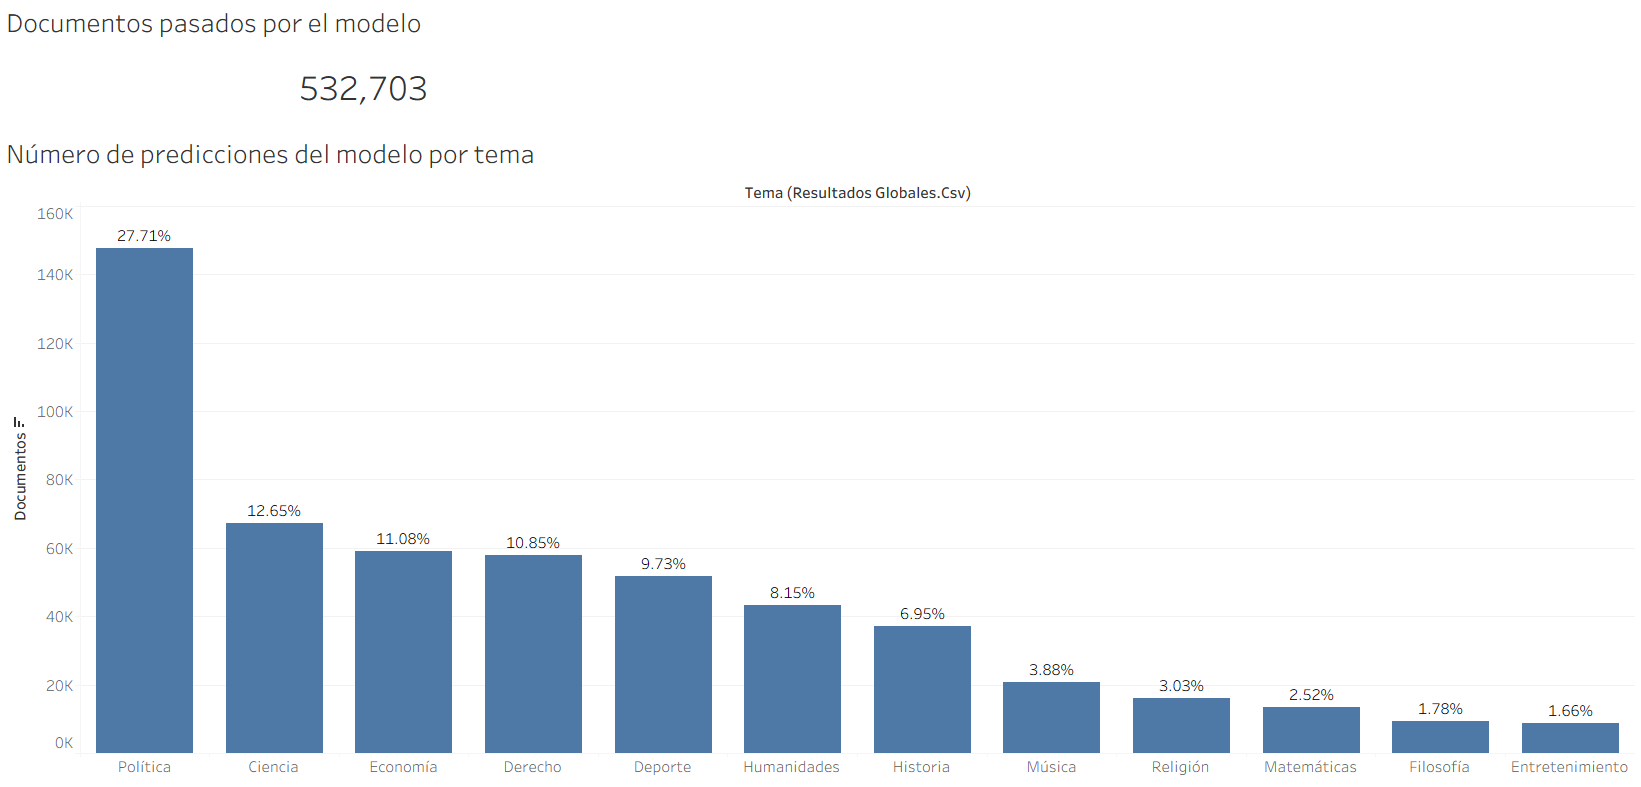

## Versiones que se usaron para este trabajo.

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
print("🔹 Spark version:", spark.version)
print("🔹 Hadoop version:", spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion())


🔹 Spark version: 4.0.1
🔹 Hadoop version: 3.4.1


## Link de Tablue Public

https://public.tableau.com/app/profile/imanol.mu.iz.ramirez/viz/NLP_17622915284760/Story1?publish=yes